Este script faz uma análise de dados a partir das informações sobre os bloquinhos de carnaval de 2024 da cidade de São Paulo (SP) disponibilizadas à FEA.Dev pela equipe do BuscaBloco :)


In [33]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb  9 21:10:10 2024

@author: CINTHYA BENEDUCCI
"""
## Importação de bibliotecas
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib.colors import LinearSegmentedColormap # criação da escala de cores
from matplotlib.ticker import FuncFormatter # Para customizar o eixo y
import folium # para criação dos mapas
import json # para criação dos mapas
import random

In [34]:
## Definições iniciais
amarelo_dev = '#f7e607'
dic_dias = {'Sunday':'Domingo',
            'Saturday': 'Sábado',
            'Monday':'Segunda',
            'Tuesday':'Terça',
            'Wednesday':'Quarta',
            'Thursday':'Quinta',
            'Friday':'Sexta'}


# Criando paleta de cores
yellow = (1, 1, 0)  # amarelo
gray = (0.5, 0.5, 0.5)  # cinza
colors = [yellow, gray]
cmap_name = 'yellow_gray'
n_bins = 1000  # Número de cores na paleta
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Definição de funções
def bar_plot(eixo_x:pd.Series, eixo_y: pd.Series, cor:str, x_label:str, y_label:str, titulo:str):
    plt.figure(figsize = (10,6))
    plt.bar(eixo_x, eixo_y, color = cor)
    plt.title(titulo)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.tick_params(axis='x', direction='in')
    
    
def pie_plot(labels, sizes, colors, title):
    plt.figure(figsize=(8, 9))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.tight_layout()
    plt.axis('equal')
    
def formatacao_pct(x, pos):
    return '{:.0%}'.format(x)
   


In [35]:

## Leitura da database
os.chdir(r'C:\Users\USUARIO\Desktop\Cinthya\python_codes\BuscaBloco')
path = os.getcwd()
file2read = path + r'\db_blocos_completa.xlsx'
db = pd.read_excel(file2read, sheet_name = 'db_completa')
quant_linhas = db.shape[0]
db.dropna(inplace = True)
print(f'Foram retiradas {quant_linhas - db.shape[0]} linhas com NA.')
db.replace({'Centro-Sul':'Centro-sul'}, inplace = True)
db.replace(dic_dias, inplace = True)
db.iloc[:,[5,6]] = db.iloc[:,[5,6]].replace({",": "."}, regex = True)

# Considerando como período de carnaval os dias 10 a 14 de fevereiro
db['carnaval'] = db['Data'].dt.day.isin([10, 11, 12, 13, 14])


Foram retiradas 256 linhas com NA.


<Figure size 1000x600 with 0 Axes>

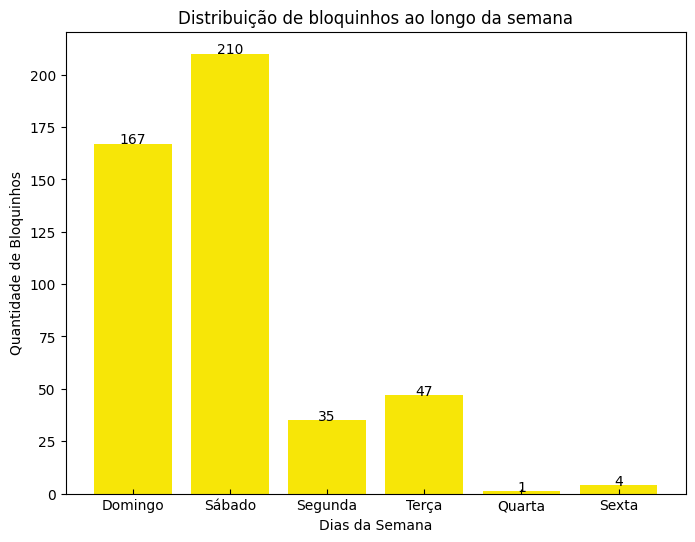

In [36]:


# Configuração da figura e dos subplots
#fig, axs = plt.subplots(3,1, figsize = (10,30), sharex=True)
plt.figure(figsize=(10, 6))

#lista_dias = list(dic_dias.values())
## Distribuição dos Bloquinhos ao longo dos dias da semana
bloquinhosDia = db['Dia'].value_counts().reset_index()
bloquinhosDia['pct'] = bloquinhosDia['count'].div(bloquinhosDia['count'].sum())
bloquinhosDia.Dia = pd.Categorical(bloquinhosDia.Dia, categories = list(dic_dias.values()),
                                    ordered = True)
bloquinhosDia.sort_values('Dia', inplace = True)
plt.figure(figsize=(8, 6))  
plt.bar(bloquinhosDia['Dia'], bloquinhosDia['count'], color = amarelo_dev)
for x,y in enumerate(bloquinhosDia['count']):
    plt.annotate(y, xy=(x, y), ha = 'center')

plt.title('Distribuição de bloquinhos ao longo da semana')
plt.xlabel('Dias da Semana')
plt.ylabel('Quantidade de Bloquinhos')
plt.tick_params(axis='x', direction='in')


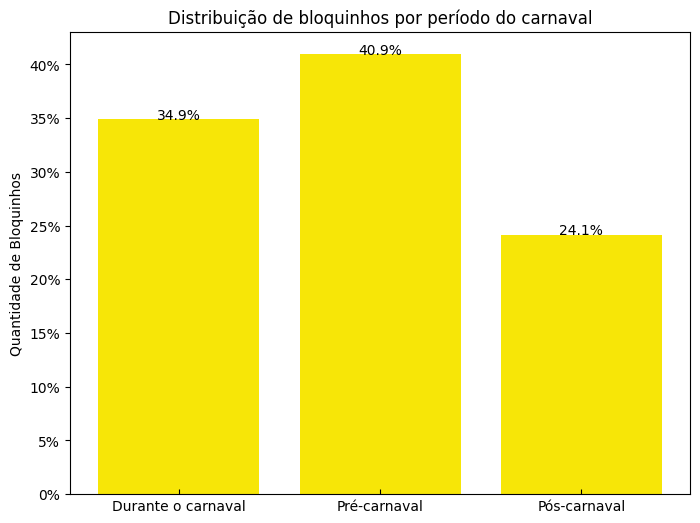

In [37]:

bloquinhosFeriado = db[db['carnaval']==True]['Dia'].value_counts().sum()
bloquinhosPre = db[db['Data'].dt.day < 10].value_counts().sum()
bloquinhosPos = db[db['Data'].dt.day > 14].value_counts().sum()

bloquinhos_diaMes = pd.DataFrame([bloquinhosFeriado, bloquinhosPre, bloquinhosPos], index = ['Durante o carnaval',
'Pré-carnaval',
'Pós-carnaval'])
bloquinhos_diaMes.reset_index(inplace = True)
bloquinhos_diaMes.columns = ['Categoria', 'Quantidade']
bloquinhos_diaMes['pct'] = bloquinhos_diaMes['Quantidade'].div(bloquinhos_diaMes['Quantidade'].sum())

bloquinhos_diaMes.head()
plt.figure(figsize=(8, 6))  
plt.bar(bloquinhos_diaMes['Categoria'], bloquinhos_diaMes['pct'], color = amarelo_dev)
for x,y in enumerate(bloquinhos_diaMes['pct']):
    plt.annotate("{:.1%}".format(y), xy=(x, y), ha = 'center')
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatacao_pct))

plt.title('Distribuição de bloquinhos por período do carnaval')
plt.ylabel('Quantidade de Bloquinhos')
plt.tick_params(axis='x', direction='in')


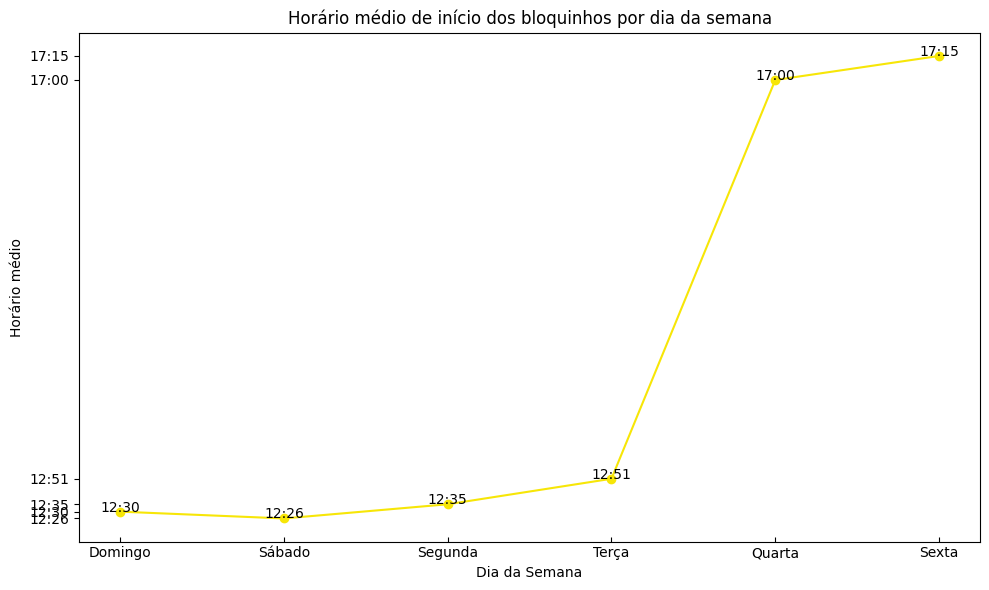

In [38]:

## Horário médio de início dos bloquinhos
# Transformando os datetime.date em segundos
def tempo_para_segundos(t):
    return t.hour * 3600 + t.minute * 60 + t.second

db['Horario em segundos'] = db['Hora'].apply(tempo_para_segundos)

# Calculando o horário médio
horario_medio = db.groupby('Dia')['Horario em segundos'].mean()
hora_media = (horario_medio.div(3600)).astype(int)
minuto_medio = (horario_medio%3600).div(60).astype(int)
segundo_medio =(horario_medio%60).astype(int)

# Eliminando a coluna do horário em segundos do dataframe original
db.drop(['Horario em segundos'], inplace = True, axis = 1)

def criar_objeto_time(hour, minute, second):
    return datetime.time(hour, minute, second)

# Transformando o horário médio em um objeto datetime.time novamente
horario_medio_dt = pd.DataFrame([criar_objeto_time(hora,minuto, segundo) for
                                 hora, minuto, segundo in
                                 zip(hora_media, minuto_medio, segundo_medio)],
                                 index = horario_medio.index,
                                 columns = ['Horario medio'])
horario_medio = pd.concat([horario_medio, horario_medio_dt], axis = 1).reset_index()


# Ordenando o dataframe pelos dias da semana
horario_medio.Dia = pd.Categorical(horario_medio.Dia, categories = list(dic_dias.values()),
                                    ordered = True)
horario_medio.sort_values('Dia', inplace = True)
# Plot do gráfico
plt.figure(figsize=(10, 6))
plt.plot(horario_medio['Dia'], horario_medio['Horario em segundos'], color = amarelo_dev, marker='o', linestyle='-')
plt.xlabel('Dia da Semana')
plt.ylabel('Horário médio')
plt.tick_params(axis='x', direction='in')

plt.title('Horário médio de início dos bloquinhos por dia da semana')
yticks_string = [str(t)[:5] for t in horario_medio['Horario medio']]
plt.yticks(horario_medio['Horario em segundos'].astype(int), yticks_string) # Substituindo as datas por strings de horário 

i = 0
for x,y in enumerate(horario_medio['Horario em segundos']):
    plt.annotate(yticks_string[i], xy=(x, y), ha = 'center')
    i+= 1
plt.tight_layout()
plt.show()


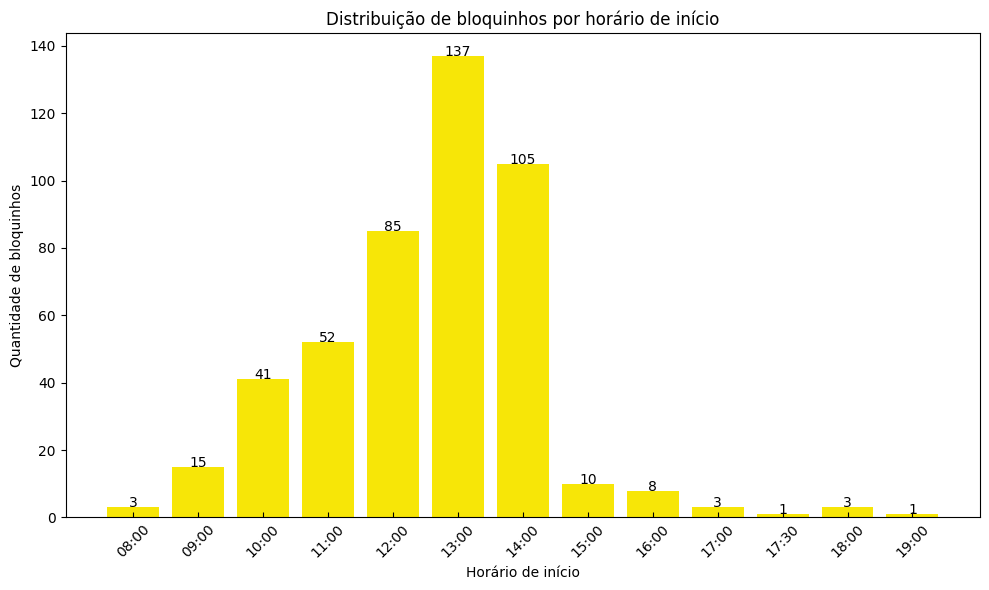

In [39]:

## Quantidade de bloquinhos por horário de início
bloquinhosHorario = pd.DataFrame(db['Hora'].value_counts()).rename({'count':'Quantidade'}, axis = 1)
bloquinhosHorario.reset_index(inplace = True)
bloquinhosHorario
bloquinhosHorario.Hora = bloquinhosHorario.Hora.astype(str).str.slice(stop=5)
bloquinhosHorario.sort_values('Hora', inplace = True)
bar_plot(bloquinhosHorario['Hora'],
         bloquinhosHorario['Quantidade'],
         cor = amarelo_dev,
         x_label = 'Horário de início',
         y_label = 'Quantidade de bloquinhos',
         titulo = 'Distribuição de bloquinhos por horário de início')
for x,y in enumerate(bloquinhosHorario['Quantidade']):
    plt.annotate(y, xy=(x, y), ha = 'center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


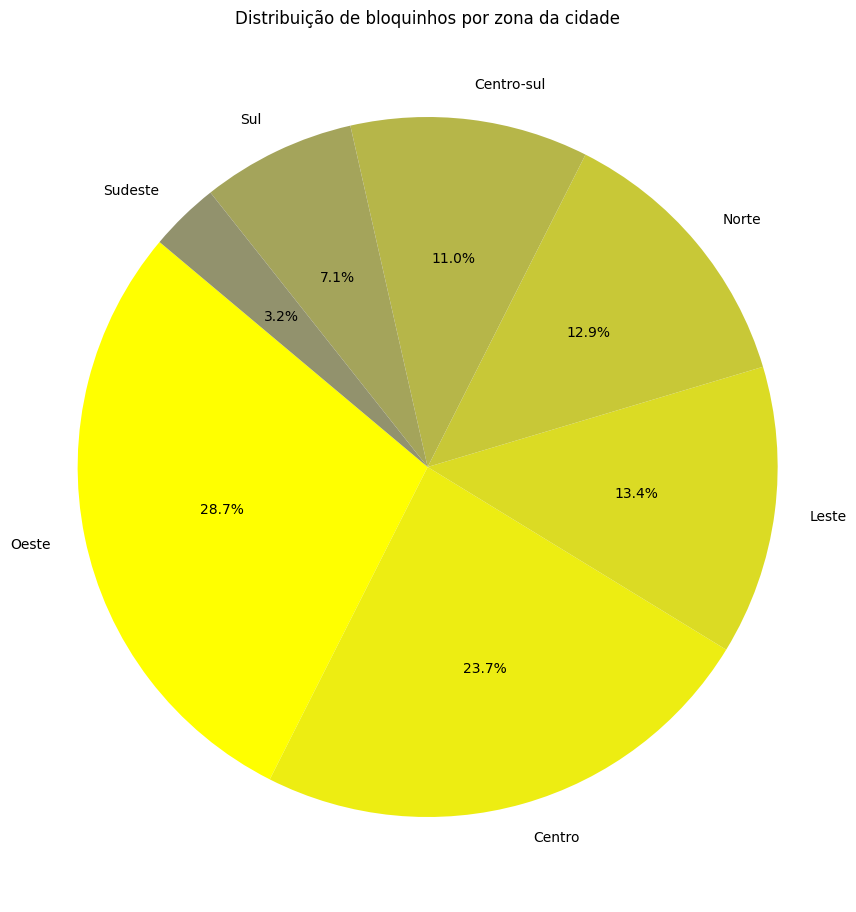

In [40]:

## Distribuição de bloquinhos por zona da cidade
bloquinhosZona = pd.DataFrame(db['Zona'].value_counts()).rename({'count':'Quantidade'},
                                                                axis = 1)
bloquinhosZona.reset_index(inplace = True)
labels = bloquinhosZona['Zona']
sizes = bloquinhosZona['Quantidade']
title = 'Distribuição de bloquinhos por zona da cidade'
pie_plot(labels, sizes, [cm(i/len(labels)) for i in range(len(labels))], title)
plt.show()



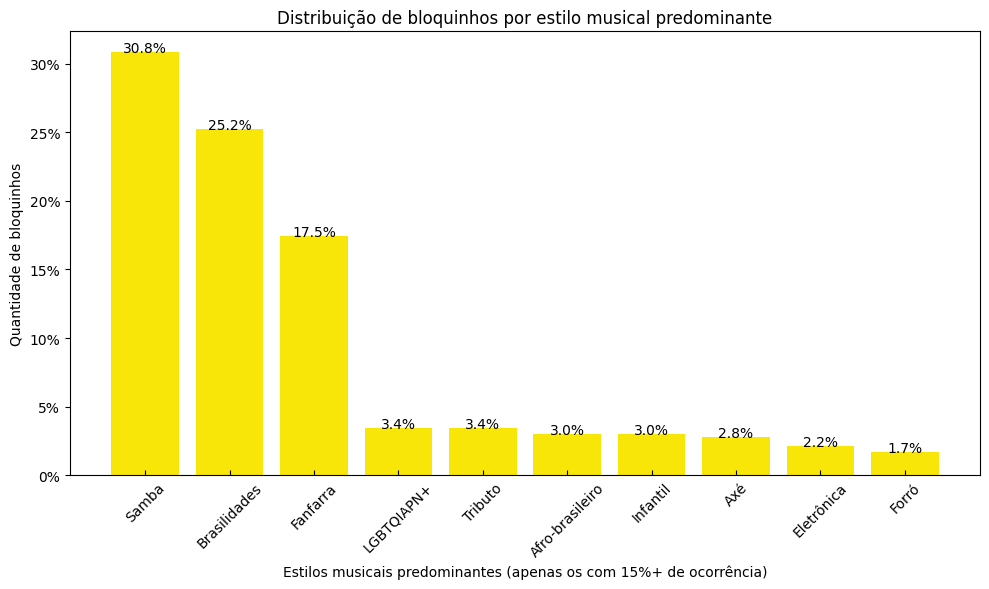

In [41]:

## Distribuição de bloquinhos por estilo musical predominante
bloquinhosEstilo = pd.DataFrame(db['Estilo Musical'].value_counts()).rename({'count':'Quantidade'},
                                                                axis = 1)
bloquinhosEstilo.reset_index(inplace = True)
bloquinhosEstilo['pct'] = bloquinhosEstilo['Quantidade'].div(bloquinhosEstilo['Quantidade'].sum())
bloquinhosEstilo = bloquinhosEstilo[bloquinhosEstilo['pct']>0.015]
bar_plot(bloquinhosEstilo['Estilo Musical'],
         bloquinhosEstilo['pct'],
         cor = amarelo_dev,
         x_label = 'Estilos musicais predominantes (apenas os com 15%+ de ocorrência)',
         y_label = 'Quantidade de bloquinhos',
         titulo = 'Distribuição de bloquinhos por estilo musical predominante')

for x,y in enumerate(bloquinhosEstilo['pct']):
    plt.annotate("{:.1%}".format(y), xy=(x, y), ha = 'center')
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatacao_pct))
plt.tight_layout()  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22184\3153165358.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_zona['pct'] = dados_zona['Quantidade'].div(dados_zona["Quantidade"].sum())
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22184\3153165358.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_zona['pct'] = dados_zona['Quantidade'].div(dados_zona["Quantidade"].sum())
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_22184\3153165358.py:20: SettingWithCopyWarning: 
A value is trying to be

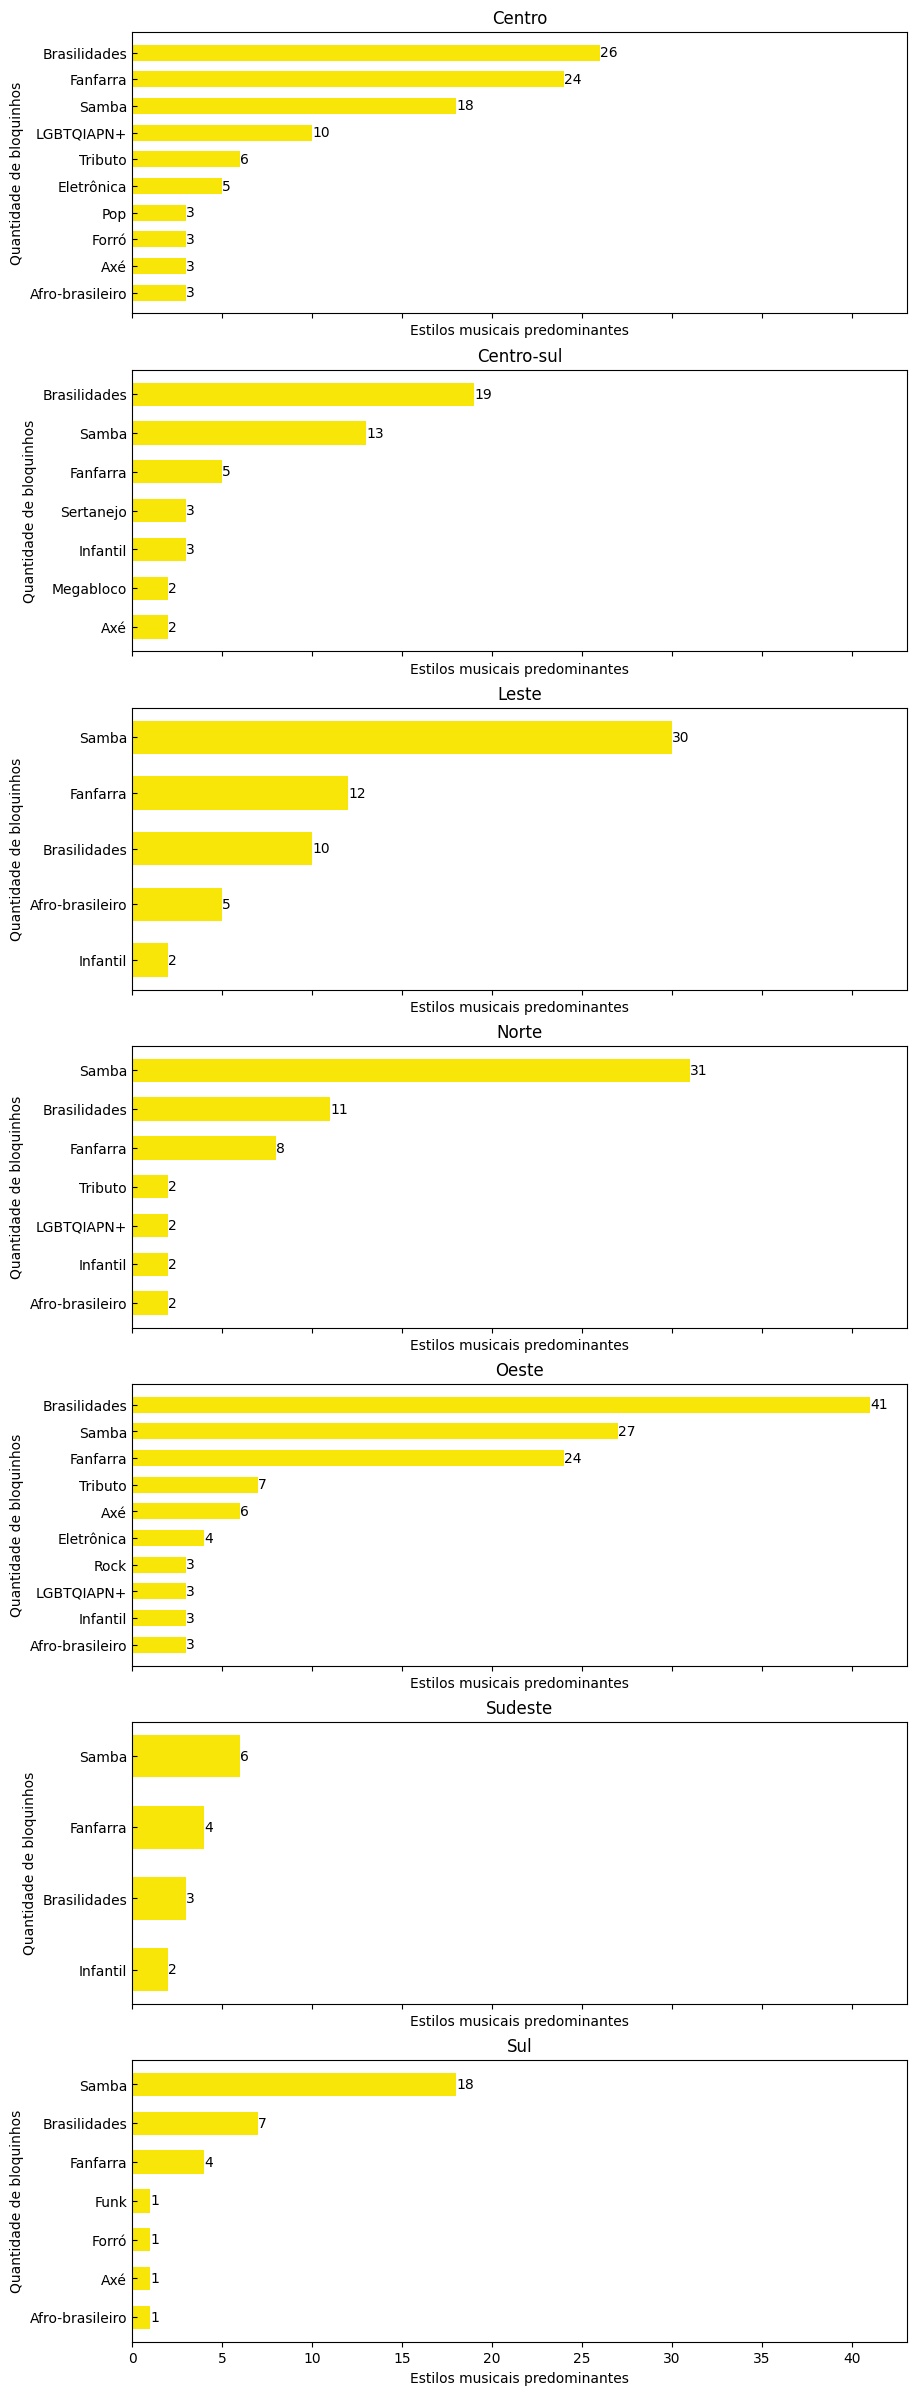

In [42]:

## Distribuição de bloquinhos por estilo musical predominante por zona
EstiloZona = pd.DataFrame(db.groupby('Zona')['Estilo Musical'].value_counts()).rename({'count':'Quantidade'},
                                                                axis = 1)
EstiloZona.reset_index(inplace = True)



zonas = EstiloZona['Zona'].unique()

# Configuração da figura e dos subplots
fig, axs = plt.subplots(7,1, figsize = (10,30), sharex=True)

x_label = "Estilos musicais predominantes"
y_label = "Quantidade de bloquinhos"
titulo = 'Distribuição de bloquinhos por estilo musical predominante'

for i, zona in enumerate(zonas):
    # Filtrando os dados para a zona atual
    dados_zona = EstiloZona[EstiloZona['Zona'] == zona]
    dados_zona['pct'] = dados_zona['Quantidade'].div(dados_zona["Quantidade"].sum())
    dados_zona = dados_zona[dados_zona['pct']>0.02] # Pegando apenas estilos com 20%+ de frequencia
    dados_zona = dados_zona.sort_values('Quantidade')
    eixo_x = dados_zona['Estilo Musical']
    eixo_y = dados_zona['Quantidade']
    
   
    axs[i].barh(eixo_x, eixo_y, height = 0.6, color = amarelo_dev)
    for y, x in enumerate(eixo_y):
        axs[i].annotate(str(x), xy=(x, y), va='center')
        
    axs[i].set_title(zona)
    axs[i].set_xlabel(x_label)
    axs[i].set_ylabel(y_label)
    axs[i].tick_params(axis='y', direction='in')
    
plt.show()

In [43]:

## Localização dos bloquinhos no mapa
# Abrindo o arquivo com os munícipios de SP delimitados
file2read = path + r'\municipios_sp.json'
with open(file2read, encoding="utf8") as f:
    geo_json_data = json.load(f)

# Criando o mapa e especificando a parte visual
localizacao = [float(db.iloc[0,5]), float(db.iloc[0,6])]
mapa = folium.Map(
    width=600,height=400,
    location= localizacao, 
    zoom_start=11
)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
    }
).add_to(mapa)
# Plotando a localização de cada bloquinho
cores_disponiveis = ['#6495ED', '#32CD32', '#FF6347', '#FFA500', '#9370DB', '#FFC0CB', '#FFFF00']
cor_marcadores = 'darkblue'
for index, row in db.iterrows():
    cor_marcador = random.choice(cores_disponiveis) # Plotando cada bloquinho com uma cor aleatória
    folium.CircleMarker([float(row['Latitude']), float(row['Longitude'])],
                        fill=True, radius=2, weight = 2.5, color= cor_marcador, fill_color=cor_marcador).add_to(mapa)
mapa.save('mapa_bloquinhos_SP.html')
print("Mapa salvo!")

Mapa salvo!
